In [138]:
import pandas as pd
import numpy as np
import heartpy as hp

# === Parameters ===
input_file = 'Raw Data/P35_S1.csv'
output_file = 'Windowed Data/P35_S1_windowed.csv'
fs = 100  # Hz
window_sec = 30
stride_sec = 10
window_size = window_sec * fs
stride_size = stride_sec * fs
theta_min = 3  # Degrees, steering reversal threshold

# === Load & sort data ===
df = pd.read_csv(input_file)
df['UTC'] = pd.to_datetime(df['UTC'], unit='ms')
df = df.sort_values('UTC').reset_index(drop=True)

# === Initialize container ===
agg_data = []

# === Sliding window ===
for start in range(0, len(df) - window_size + 1, stride_size):
    window = df.iloc[start:start + window_size]

    # --- ECG heart rate using HeartPy ---
    ecg_signal = window['Physio_ECG'].values
    try:
        _, measures = hp.process(ecg_signal, sample_rate=fs)
        heart_rate = measures['bpm']
    except:
        heart_rate = np.nan

    # --- GSR metrics ---
    gsr_mean = window['Physio_GSR'].mean()
    gsr_std = window['Physio_GSR'].std()

    # --- Lane deviation ---
    lane_std = window['laneDev_OffsetfrmLaneCentre'].std()

    # --- Speed metrics ---
    speed_std = window['speed'].std()
    speed_mean = window['speed'].mean()

    # --- Steering Wheel Reversal Rate (SWRR) using SAE method ---
    sw_angle = window['swAngle'].values
    indicator = np.zeros_like(sw_angle)

    last_extreme = sw_angle[0]
    for i in range(1, len(sw_angle)):
        if abs(sw_angle[i] - last_extreme) >= theta_min:
            indicator[i] = 1
            last_extreme = sw_angle[i]

    sw_rr = np.sum(indicator) / window_sec  # Rate: reversals per second

    # --- Store features ---
    agg_data.append({
        'window_start': window['UTC'].iloc[0],
        'window_end': window['UTC'].iloc[-1],
        'ECG_HR': heart_rate,
        'GSR_mean': gsr_mean,
        'GSR_std': gsr_std,
        'laneDev_std': lane_std,
        'speed_mean': speed_mean,
        'speed_std': speed_std,
        'swAngle_SWRR': sw_rr,
        'ID': window['ID'].iloc[0] if 'ID' in window.columns else None,
        'Label': window['Label'].iloc[0] if 'Label' in window.columns else None
    })

# === Save result ===
agg_df = pd.DataFrame(agg_data)
agg_df.to_csv(output_file, index=False)
print(f"Saved aggregated windowed data to: {output_file}")

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/heartpy/analysis.py:677: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)
/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/numpy/ma/core.py:5415: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Saved aggregated windowed data to: Windowed Data/P35_S1_windowed.csv


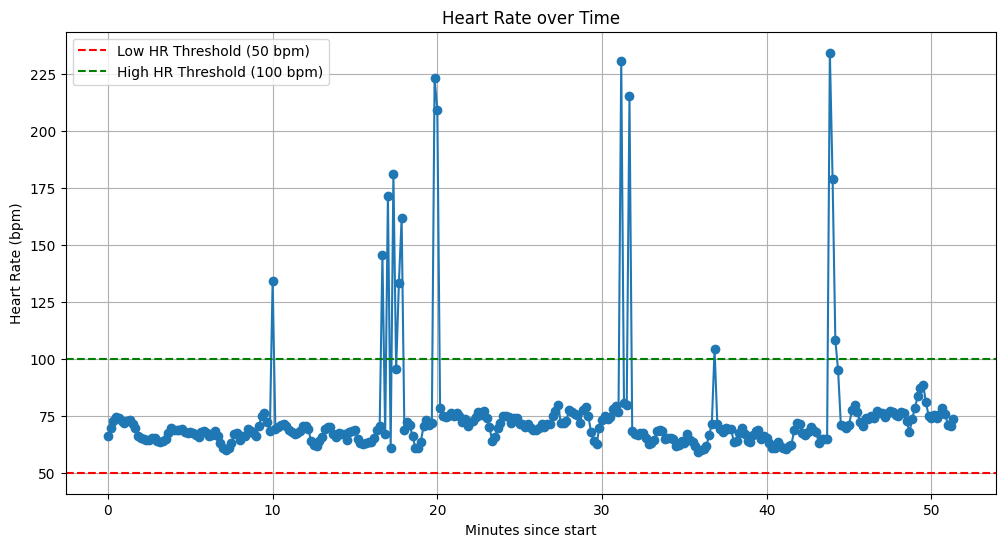

Low HR rows (<50 bpm): 0 (0.00%)
High HR rows (>100 bpm): 14 (4.53%)


In [139]:
import matplotlib.pyplot as plt

input_file = 'Windowed Data/P35_S1_windowed.csv'
df = pd.read_csv(input_file)

# Visualize the heart rate
x = np.arange(len(df)) * (stride_sec / 60)  # Convert to minutes

plt.figure(figsize=(12,6))
plt.plot(x, df['ECG_HR'], marker='o')
plt.xlabel('Minutes since start')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate over Time')
plt.grid()

# Draw high and low heart rate zones on the plot
plt.axhline(y=50, color='r', linestyle='--', label='Low HR Threshold (50 bpm)')
plt.axhline(y=100, color='g', linestyle='--', label='High HR Threshold (100 bpm)')

plt.legend()
plt.show()

# Save low and high heart rate rows in a dataframe
low_hr_df = df[df['ECG_HR'] < 50]
high_hr_df = df[df['ECG_HR'] > 100]

# Compute percentage of rows removed
total_rows = len(df)
low_hr_percentage = (len(low_hr_df) / total_rows) * 100
high_hr_percentage = (len(high_hr_df) / total_rows) * 100
print(f"Low HR rows (<50 bpm): {len(low_hr_df)} ({low_hr_percentage:.2f}%)")
print(f"High HR rows (>100 bpm): {len(high_hr_df)} ({high_hr_percentage:.2f}%)")

In [140]:
import pandas as pd

# Load the aggregated CSV
df = pd.read_csv("Windowed Data/P35_S1_windowed.csv")  # Change to your actual filename

# Remove rows with NaN heart rate
df = df.dropna(subset=['ECG_HR'])

# Remove rows with no Label
df = df[df['Label'].notna()]

# Compute heart rate bounds based on low and high heart rate thresholds from previous analysis
low_hr_threshold = 50
high_hr_threshold = 90

# Filter rows based on heart rate thresholds
removed_rows = df[(df['ECG_HR'] < low_hr_threshold) | (df['ECG_HR'] > high_hr_threshold)]
kept_rows = df[(df['ECG_HR'] >= low_hr_threshold) & (df['ECG_HR'] <= high_hr_threshold)]

# Save cleaned version
kept_rows.to_csv("Intermediate Folder/P35_S1_windowed_cleaned.csv", index=False)

# Print removed rows
print(removed_rows[['window_start', 'window_end', 'ECG_HR']])
print(f"\nTotal rows removed: {len(removed_rows)}")
print(f"\nPercentage of rows removed: {len(removed_rows) / len(df) * 100:.2f}%")

# Saved removed rows to csv
removed_rows.to_csv("Removed Data/P35_S1_windowed_removed.csv", index=False)

                window_start               window_end      ECG_HR
60   2022-04-10 19:22:27.340  2022-04-10 19:22:59.157  134.328358
100  2022-04-10 19:29:32.369  2022-04-10 19:30:04.174  145.552561
102  2022-04-10 19:29:53.583  2022-04-10 19:30:25.431  171.428571
104  2022-04-10 19:30:14.839  2022-04-10 19:30:46.654  181.268882
105  2022-04-10 19:30:25.442  2022-04-10 19:30:57.272   95.427435
106  2022-04-10 19:30:36.047  2022-04-10 19:31:07.876  133.333333
107  2022-04-10 19:30:46.665  2022-04-10 19:31:18.495  161.702128
119  2022-04-10 19:32:53.994  2022-04-10 19:33:25.838  223.194748
120  2022-04-10 19:33:04.604  2022-04-10 19:33:36.448  209.445585
187  2022-04-10 19:44:56.550  2022-04-10 19:45:28.362  230.769231
190  2022-04-10 19:45:28.373  2022-04-10 19:46:00.235  215.189873
221  2022-04-10 19:50:57.368  2022-04-10 19:51:29.579  104.347826
263  2022-04-10 19:58:23.552  2022-04-10 19:58:55.822  234.375000
264  2022-04-10 19:58:34.186  2022-04-10 19:59:06.407  178.807947
265  2022-

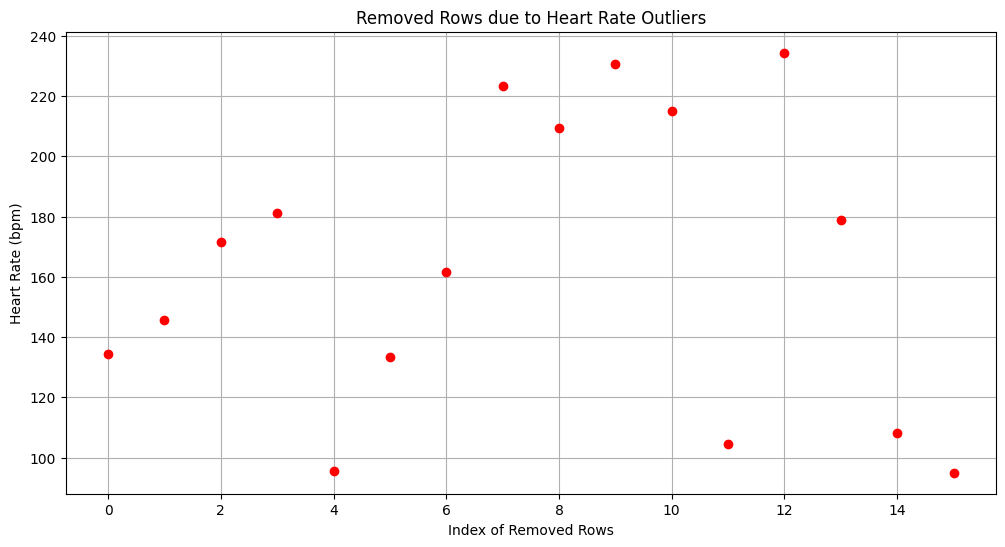

In [141]:
# Visualize the removed rows
plt.figure(figsize=(12,6))
plt.plot(removed_rows['ECG_HR'].values, marker='o', linestyle='', color='r')
plt.xlabel('Index of Removed Rows')
plt.ylabel('Heart Rate (bpm)')
plt.title('Removed Rows due to Heart Rate Outliers')
plt.grid()
plt.show()

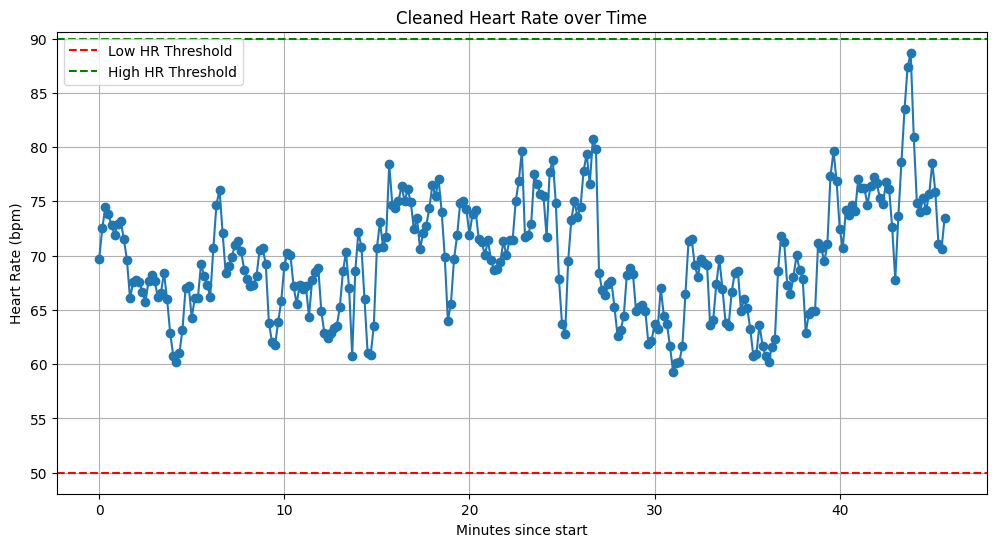

In [142]:
# Visualize the cleaned heart rate data
import matplotlib.pyplot as plt
x = np.arange(len(kept_rows)) * (stride_sec / 60)  # Convert to minutes
plt.figure(figsize=(12,6))
plt.plot(x, kept_rows['ECG_HR'], marker='o')
plt.xlabel('Minutes since start')
plt.ylabel('Heart Rate (bpm)')
plt.title('Cleaned Heart Rate over Time')
plt.grid()
plt.axhline(y=low_hr_threshold, color='r', linestyle='--', label='Low HR Threshold')
plt.axhline(y=high_hr_threshold, color='g', linestyle='--', label='High HR Threshold')
plt.legend()

# Save the figure
plt.savefig("HR_Plots/Pre Interpolation/P35.png", dpi=150)
plt.show()